# Building Integrated Stroke Delivery Network (ISDN) footprint geometry

This notebook shows how to build up the geometry of ISDNs from smaller regions of the country. The smaller regions are named either Sustainability and Transformation Partnerships (STPs) or Integrated Care Boards (ICBs) depending on the age of the data. In some cases there are slight mismatches in STPs/ICBs and the reference ISDN maps due to some smaller units being used instead. These smaller units are Clinical Commissioning Groups (CCGs) and Sub Integrated Care Board Locations (SICBLs).

We use reference maps of the ISDN areas to work out which STPs or ICBs should be in each ISDN.

This notebook takes each available STP and ICB data set in turn and uses it to recreate the reference maps in the same colours.

## Reference maps

There are two reference maps:

| Green map | Multi-coloured map |
| :---: | :---: |
| ![](images/ISDN_footprints_networks-for-future-healthcare_hargroves.jpg) | ![](images/ISDN_footprints_girft-programme-national-specialty-report_hargroves.png) |
| Name: "Figure 1" | Name: "Figure 4" |
| Caption: "Adapted with permission from NHS England. Integrated stroke delivery network footprints. NHS, 2020." | Title: "Figure 4: Integrated Stroke Delivery Network footprints (December 2020)" |
| [Available online](https://www.rcpjournals.org/content/futurehosp/9/2/118) (accessed 13th February 2024). | [Available online](https://gmnisdn.org.uk/wp-content/uploads/2022/04/Stroke-GiRFT-report-Apr-22.pdf) |
| Networks for future healthcare; David Hargroves, Deborah Lowe, Marion Wood, Simon Ray; Future Healthc J Jul 2022, 9 (2) 118-124; DOI: 10.7861/fhj.2022-0048 | Stroke; GIRFT Programme National Specialty Report; By Dr David Hargroves and Dr Deb Lowe; GIRFT Clinical Lead for Stroke and Senior Clinical Advisor for Stroke; April 2022 |

Note: The multi-coloured map title says 2020 and the document containing it is from 2022.

I assume this multicoloured map was used to create the green map.

## Summary of region file differences

n.b. STPs were renamed to ICBs starting from July 2022.

| File | Differences from previous |
| --- | --- |
| STP 2017 (Feb) | -- |
| STP 2018 (Apr) | Three STPs in Cumbria were merged into one. 'Durham, Darlington, Teesside, Hambleton, Richmondshire and Whitby', 'Northumberland, Tyne and Wear and North Durham', and 'West, North and East Cumbria' became 'Cumbria and North East'. |
| STP 2019 (Apr) | Various STP names change. |
| STP 2020 (Apr) | Big changes to borders of Sussex/Surrey (top middle of Sussex) and Yorkshire/Cumbria. In Yorkshire/Cumbria, the CCG "NHS Hambleton, Richmondshire and Whitby CCG" moves from STP "Cumbria and North East" to "Humber, Coast and Vale". Extra small change to border of Sussex/Surrey in their West. Various name changes. |
| STP 2021 (Apr) | Sussex changes its name. |
| ICB 2022 (Jul) | Big change around Worksop, "NHS Bassetlaw CCG" moves from South Yorkshire to Nottinghamshire. Slight change through Birmingham / Black Country border. |
| ICB 2023 (Apr) | Reinstated extra small change to border of Sussex/Surrey in their west. |


## Notebook setup

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
# For merging polygons:
from shapely.geometry import Polygon, mapping
from shapely.ops import unary_union
# For drawing the images on plots:
from PIL import Image
# For tracking paths to files:
from dataclasses import dataclass

In [2]:
# Define file paths
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    dir_input = '../data_geojson/ons_data'
    dir_images = 'images'
    dir_output = 'output_images'

    image_multi = 'ISDN_footprints_girft-programme-national-specialty-report_hargroves.png'
    image_green = 'ISDN_footprints_networks-for-future-healthcare_hargroves.jpg'

    stp2017 = 'STP_Feb_2017_GCB_in_England_2022_8567178081442829795.geojson'
    stp2018 = 'Sustainability_and_Transformation_Partnerships_April_2018_EN_BUC_2022_-2759901949355012834.geojson'
    stp2019 = 'STP_Apr_2019_GCB_in_England_2022_3138810296697318496.geojson'
    stp2020 = 'STP_Apr_2020_GCB_in_England_2022_-1081521755956819308.geojson'
    stp2021 = 'Sustainability_and_Transformation_Partnerships_April_2021_EN_BUC_V2_2022_8439332109500903668.geojson'
    icb2022 = 'ICB_JUL_2022_EN_BGC_V3_7901616774526941461.geojson'
    icb2023 = 'Integrated_Care_Boards_April_2023_EN_BGC_-5820614070354969176(1).geojson'

paths = Paths()

## Functions for gathering regions and making a map:

In [3]:
def main(path_to_file, col_name):
    """
    Main function to load data, assign colours, and make maps.

    Each gdf has a different name for the column that stores the
    region names, so set this with `col_name`.
    """
    # Import region file:
    gdf_boundaries = geopandas.read_file(path_to_file)
    
    print(gdf_boundaries.columns)
    
    gdf_boundaries = gdf_boundaries.set_index(col_name)
    
    for colour, colour_series in colour_series_dict.items():
        gdf_boundaries_colours, gdf_boundaries_isdn = make_data_for_map(
            gdf_boundaries,
            isdn_series,
            colour_series
        )
        plot_map(
            gdf_boundaries_colours,
            gdf_boundaries_isdn,
            image_dict[colour],
            title=col_name,
            savename=os.path.join(paths.dir_output,
                                  f'{col_name}_{colour}.jpg')
        )

In [4]:
def make_data_for_map(gdf_boundaries, isdn_series, colour_series):
    """
    Assign the ISDN label and colours to each region in the gdf.
    """
    # Merge the colours into the ISDN names:
    df_isdn_regions = pd.merge(
        isdn_series, colour_series,
        left_on='ISDN', right_index=True
    )
    # Merge colours into the boundaries:
    gdf_boundaries = pd.merge(
        gdf_boundaries, df_isdn_regions,
        left_index=True, right_index=True, how='left'
    )

    # Create an extra second gdf for the maps.
    # Glob together smaller regions to make ISDN polygons.
    # These will be used to show only the outer edges of each ISDN.
    gdf_boundaries_isdn = gdf_boundaries[
        ['ISDN', 'geometry', 'colour']].dissolve(by='ISDN')

    return gdf_boundaries, gdf_boundaries_isdn

In [5]:
def plot_map(
        gdf_boundaries,
        gdf_boundaries_isdn,
        image_data,
        title='',
        savename=''
        ):
    """
    Main map plotting function. Reference image on left, map on right.
    """
    # Plot:    
    fig, axs = plt.subplots(
        1, 2, figsize=(14, 7.5), gridspec_kw={'wspace':0.0})

    ax0 = axs[0]
    ax = axs[1]

    ax0.imshow(image_data)
    ax0.axis('off')

    # Individual ICBs/STPs with colours to match reference image:
    gdf_boundaries.plot(
        ax=ax,
        facecolor=gdf_boundaries['colour'],
        antialiased=False,
        edgecolor='#00000011',  # quite transparent black
        linewidth=0.2,
    )

    # ISDN outlines:
    gdf_boundaries_isdn.plot(
        ax=ax,
        edgecolor='silver',
        facecolor='none',
        antialiased=False,
        linewidth=0.2,
    )
    
    ax.set_axis_off()  # Turn off axis line and numbers

    # Write the boundary type at the top left of the map axis.
    plt.annotate(title, xy=(0.0, 1.0), xycoords='axes fraction',
                 weight='bold', fontsize=20, ha='left', va='top')

    if len(savename) > 0:
        plt.savefig(savename, dpi=300, bbox_inches='tight')
    plt.show()

## Load reference images

Load in the image data for plotting:

In [6]:
image_multi = np.asarray(Image.open(
    os.path.join(paths.dir_images, paths.image_multi)))
image_green = np.asarray(Image.open(
    os.path.join(paths.dir_images, paths.image_green)))
# Place the image data into a dictionary with the same keys
# as the colour_dict:
image_dict = {
    'greens': image_green,
    'multi': image_multi
}

## Colour setup

From green map:

In [7]:
colour_greens_dict = {
    'North East and Cumbria': '#89bd3e',  # Lime green
    'West Yorkshire and Harrogate': '#89bd3e',  # Lime green
    'Humber Coast and Vale': '#89bd3e',  # Lime green
    'South Yorkshire': '#89bd3e',  # Lime green
    'Greater Manchester': '#cdda88',  # Pale green
    'Cheshire and Merseyside': '#cdda88',  # Pale green
    'Lancashire and South Cumbria': '#cdda88',  # Pale green
    'North Midlands': '#0c733c',  # Dark green
    'East Midlands': '#0c733c',  # Dark green
    'West Midlands': '#0c733c',  # Dark green
    'East of England (South)': '#989fa5',  # Mid grey
    'East of England (North)': '#989fa5',  # Mid grey
    'London': '#030303',  # black
    'Kent and Medway': '#454f51',  # Dark grey
    'Sussex': '#454f51',  # Dark grey
    'Frimley ICS': '#454f51',  # Dark grey
    'Wessex': '#454f51',  # Dark grey
    'Thames Valley': '#454f51',  # Dark grey
    'Devon, Cornwall and Isles of Scilly': '#c9cdd0',  # light grey
    'Gloucester, BSW, BNSSG and Somerset': '#c9cdd0',  # light grey
}

In [8]:
colour_greens_series = pd.Series(colour_greens_dict, name='colour')
colour_greens_series.index.name = 'ISDN'

From multicoloured map:

In [9]:
colour_multi_dict = {
    'North East and Cumbria': '#1673be',  # Mid blue
    'West Yorkshire and Harrogate': '#1673be',  # Mid blue
    'Humber Coast and Vale': '#1673be',  # Mid blue
    'South Yorkshire': '#1673be',  # Mid blue
    'Greater Manchester': '#464d4b',  # Grey
    'Cheshire and Merseyside': '#464d4b',  # Grey
    'Lancashire and South Cumbria': '#464d4b',  # Grey
    'North Midlands': '#c52c82',  # Pink
    'East Midlands': '#c52c82',  # Pink
    'West Midlands': '#c52c82',  # Pink
    'East of England (South)': '#0f3b85',  # Dark blue
    'East of England (North)': '#0f3b85',  # Dark blue
    'London': '#29a79b',  # Teal
    'Kent and Medway': '#ff8d27',  # Orange
    'Sussex': '#ff8d27',  # Orange
    'Frimley ICS': '#ff8d27',  # Orange
    'Wessex': '#ff8d27',  # Orange
    'Thames Valley': '#ff8d27',  # Orange
    'Devon, Cornwall and Isles of Scilly': '#30b1db',  # light blue
    'Gloucester, BSW, BNSSG and Somerset': '#30b1db',  # light blue
}

In [10]:
colour_multi_series = pd.Series(colour_multi_dict, name='colour')
colour_multi_series.index.name = 'ISDN'

All colour maps:

In [11]:
colour_series_dict = {
    'greens': colour_greens_series,
    'multi': colour_multi_series
}

## ISDN allocation

Manually assign ISDNs to the STP and ICB names.

Put this into two separate dictionaries just to stop them becoming too huge. Afterwards combine both dictionaries and turn the combo into a Series.

In [12]:
# Manually assign an ISDN to these regions:
stp_isdn_dict = {
    # From 2017:
    'West Yorkshire': 'West Yorkshire and Harrogate',
    'Humber, Coast and Vale': 'Humber Coast and Vale',
    'Greater Manchester': 'Greater Manchester',
    'Cheshire and Merseyside': 'Cheshire and Merseyside',
    'South Yorkshire and Bassetlaw': 'South Yorkshire',
    'Staffordshire': 'North Midlands',
    'Shropshire and Telford and Wrekin': 'North Midlands',
    'Derbyshire': 'East Midlands',
    'Lincolnshire': 'East Midlands',
    'Nottinghamshire': 'East Midlands',
    'Leicester, Leicestershire and Rutland': 'East Midlands',
    'The Black Country': 'North Midlands',
    'Birmingham and Solihull': 'West Midlands',
    'Coventry and Warwickshire': 'West Midlands',
    'Herefordshire and Worcestershire': 'West Midlands',
    'Northamptonshire': 'East Midlands',
    'Cambridgeshire and Peterborough': 'East of England (South)',
    'Norfolk and Waveney': 'East of England (North)',
    'Suffolk and North East Essex': 'East of England (North)',
    'Milton Keynes, Bedfordshire and Luton': 'East of England (South)',
    'Hertfordshire and West Essex': 'East of England (South)',
    'Mid and South Essex': 'East of England (South)',
    'North West London': 'London',
    'North Central London': 'London',
    'North East London': 'London',
    'South East London': 'London',
    'South West London': 'London',
    'Kent and Medway': 'Kent and Medway',
    'Sussex and East Surrey': 'Sussex',
    'Frimley Health': 'Frimley ICS',
    'Surrey Heartlands': 'Frimley ICS',
    'Cornwall and the Isles of Scilly': 'Devon, Cornwall and Isles of Scilly',
    'Devon': 'Devon, Cornwall and Isles of Scilly',
    'Somerset': 'Gloucester, BSW, BNSSG and Somerset',
    'Bristol, North Somerset and South Gloucestershire': 'Gloucester, BSW, BNSSG and Somerset',
    'Bath, Swindon and Wiltshire': 'Gloucester, BSW, BNSSG and Somerset',
    'Dorset': 'Wessex',
    'Hampshire and the Isle of Wight': 'Wessex',
    'Gloucestershire': 'Gloucester, BSW, BNSSG and Somerset',
    'Buckinghamshire, Oxfordshire and Berkshire West': 'Thames Valley',
    'Durham, Darlington, Teesside, Hambleton, Richmondshire and Whitby': 'North East and Cumbria',
    'Northumberland, Tyne and Wear and North Durham': 'North East and Cumbria',
    'West, North and East Cumbria': 'North East and Cumbria',
    'Lancashire and South Cumbria': 'Lancashire and South Cumbria',
    # From 2018:
   'Cumbria and North East': 'North East and Cumbria',
    # From 2019:
    'West Yorkshire and Harrogate (Health and Care Partnership)': 'West Yorkshire and Harrogate',
    'Greater Manchester Health and Social Care Partnership': 'Greater Manchester',
    'Staffordshire and Stoke on Trent': 'North Midlands',
    'Joined Up Care Derbyshire': 'East Midlands',
    'Nottingham and Nottinghamshire Health and Care': 'East Midlands',
    'The Black Country and West Birmingham': 'North Midlands',
    'Birmingham and Solihull': 'West Midlands',
    'Norfolk and Waveney Health and Care Partnership': 'East of England (North)',
    'Bedfordshire, Luton and Milton Keynes': 'East of England (South)',
    'North West London Health and Care Partnership': 'London',
    'North London Partners in Health and Care': 'London',
    'East London Health and Care Partnership': 'London',
    'Our Healthier South East London': 'London',
    'South West London Health and Care Partnership': 'London',
    'Bath and North East Somerset, Swindon and Wiltshire': 'Gloucester, BSW, BNSSG and Somerset',
    'Healthier Lancashire and South Cumbria': 'Lancashire and South Cumbria',
    # From 2020:
    'Frimley Health and Care ICS': 'Frimley ICS',
    'Cornwall and the Isles of Scilly Health and Social Care Partnership': 'Devon, Cornwall and Isles of Scilly',
    # From 2021:
    'Sussex Health and Care Partnership': 'Sussex',
    'Surrey Heartlands Health and Care Partnership': 'Frimley ICS',
    'Sussex and East Surrey Health and Care Partnership': 'Sussex',
}

In [13]:
icb_isdn_dict = {
    # ICB 2022:
    'NHS Cheshire and Merseyside Integrated Care Board': 'Cheshire and Merseyside',
    'NHS Staffordshire and Stoke-on-Trent Integrated Care Board': 'North Midlands',
    'NHS Shropshire, Telford and Wrekin Integrated Care Board': 'North Midlands',
    'NHS Lincolnshire Integrated Care Board': 'East Midlands',
    'NHS Leicester, Leicestershire and Rutland Integrated Care Board': 'East Midlands',
    'NHS Coventry and Warwickshire Integrated Care Board': 'West Midlands',
    'NHS Herefordshire and Worcestershire Integrated Care Board': 'West Midlands',
    'NHS Norfolk and Waveney Integrated Care Board': 'East of England (North)',
    'NHS Suffolk and North East Essex Integrated Care Board': 'East of England (North)',
    'NHS Bedfordshire, Luton and Milton Keynes Integrated Care Board': 'East of England (South)',
    'NHS Hertfordshire and West Essex Integrated Care Board': 'East of England (South)',
    'NHS Mid and South Essex Integrated Care Board': 'East of England (South)',
    'NHS North West London Integrated Care Board': 'London',
    'NHS North Central London Integrated Care Board': 'London',
    'NHS North East London Integrated Care Board': 'London',
    'NHS South East London Integrated Care Board': 'London',
    'NHS South West London Integrated Care Board': 'London',
    'NHS Kent and Medway Integrated Care Board': 'Kent and Medway',
    'NHS Frimley Integrated Care Board': 'Frimley ICS',
    'NHS Cornwall and the Isles of Scilly Integrated Care Board': 'Devon, Cornwall and Isles of Scilly',
    'NHS Devon Integrated Care Board': 'Devon, Cornwall and Isles of Scilly',
    'NHS Somerset Integrated Care Board': 'Gloucester, BSW, BNSSG and Somerset',
    'NHS Bristol, North Somerset and South Gloucestershire Integrated Care Board': 'Gloucester, BSW, BNSSG and Somerset',
    'NHS Bath and North East Somerset, Swindon and Wiltshire Integrated Care Board': 'Gloucester, BSW, BNSSG and Somerset',
    'NHS Dorset Integrated Care Board': 'Wessex',
    'NHS Hampshire and Isle of Wight Integrated Care Board': 'Wessex',
    'NHS Gloucestershire Integrated Care Board': 'Gloucester, BSW, BNSSG and Somerset',
    'NHS Buckinghamshire, Oxfordshire and Berkshire West Integrated Care Board': 'Thames Valley',
    'NHS Lancashire and South Cumbria Integrated Care Board': 'Lancashire and South Cumbria',
    'NHS North East and North Cumbria Integrated Care Board': 'North East and Cumbria',
    'NHS Humber and North Yorkshire Integrated Care Board': 'Humber Coast and Vale',
    'NHS Surrey Heartlands Integrated Care Board': 'Frimley ICS',
    'NHS Sussex Integrated Care Board': 'Sussex',
    'NHS West Yorkshire Integrated Care Board': 'West Yorkshire and Harrogate',
    'NHS Birmingham and Solihull Integrated Care Board': 'West Midlands',
    'NHS Cambridgeshire and Peterborough Integrated Care Board': 'East of England (South)',
    'NHS Greater Manchester Integrated Care Board': 'Greater Manchester',
    'NHS Derby and Derbyshire Integrated Care Board': 'East Midlands',
    'NHS Northamptonshire Integrated Care Board': 'East Midlands',
    'NHS Nottingham and Nottinghamshire Integrated Care Board': 'East Midlands',
    'NHS South Yorkshire Integrated Care Board': 'South Yorkshire',
    'NHS Black Country Integrated Care Board': 'North Midlands'
    # From 2023: no changes.
}

In [14]:
# Convert region-to-ISDN dictionaries into a Series:
isdn_series = pd.Series(stp_isdn_dict | icb_isdn_dict, name='ISDN')

## Create maps

### STP 2017

Index(['OBJECTID', 'stp17cd', 'stp17nm', 'bng_e', 'bng_n', 'long', 'lat',
       'GlobalID', 'geometry'],
      dtype='object')


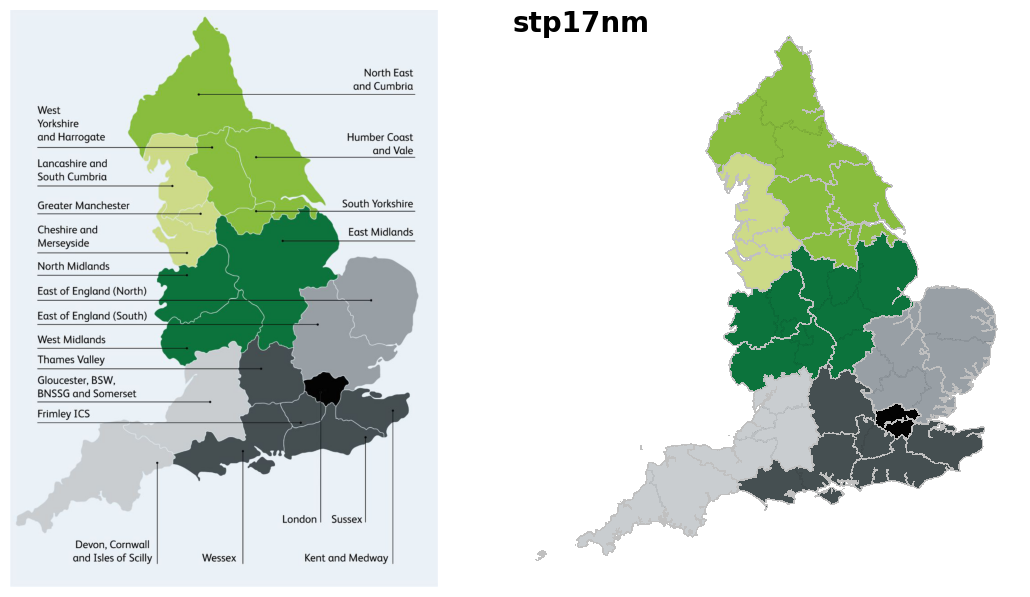

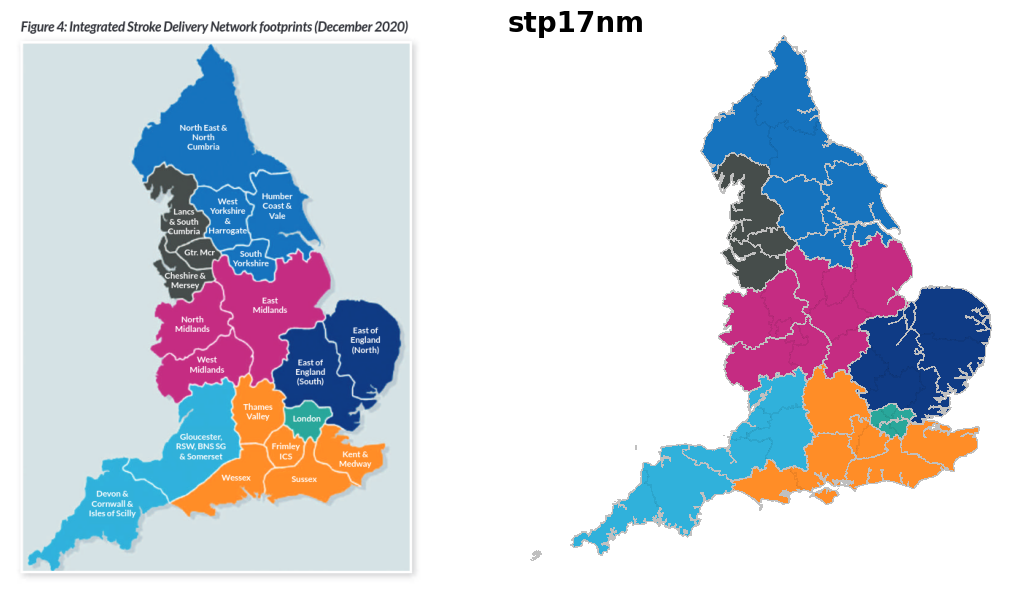

In [15]:
file_input = os.path.join(paths.dir_input, paths.stp2017)
col_name = 'stp17nm'

main(file_input, col_name)

### STP 2018

Index(['OBJECTID', 'stp18cd', 'stp18nm', 'bng_e', 'bng_n', 'long', 'lat',
       'GlobalID', 'geometry'],
      dtype='object')


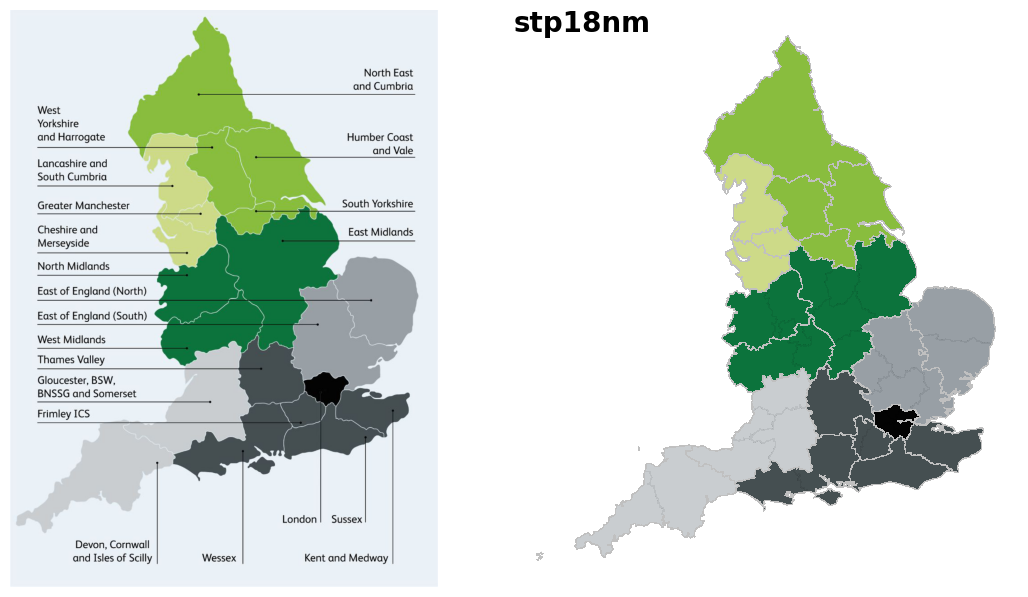

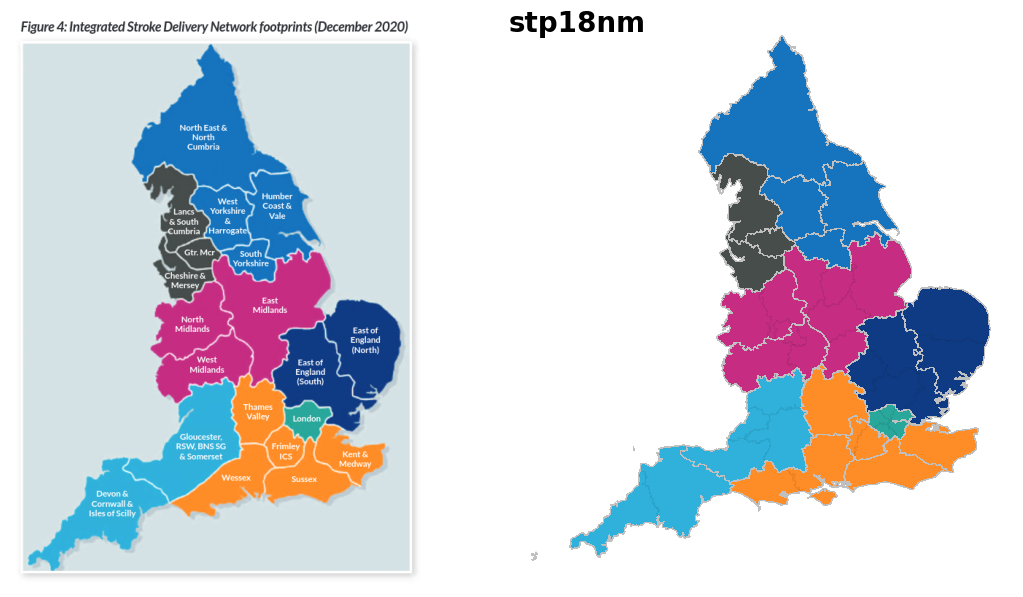

In [16]:
file_input = os.path.join(paths.dir_input, paths.stp2018)
col_name = 'stp18nm'

main(file_input, col_name)

### STP 2019

Index(['OBJECTID', 'stp19cd', 'stp19nm', 'bng_e', 'bng_n', 'long', 'lat',
       'GlobalID', 'geometry'],
      dtype='object')


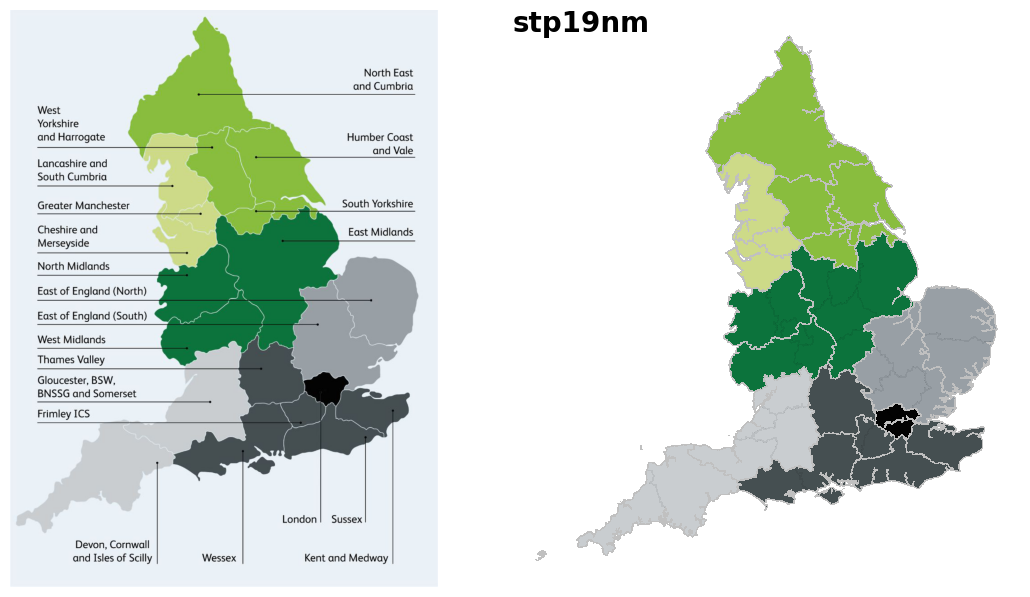

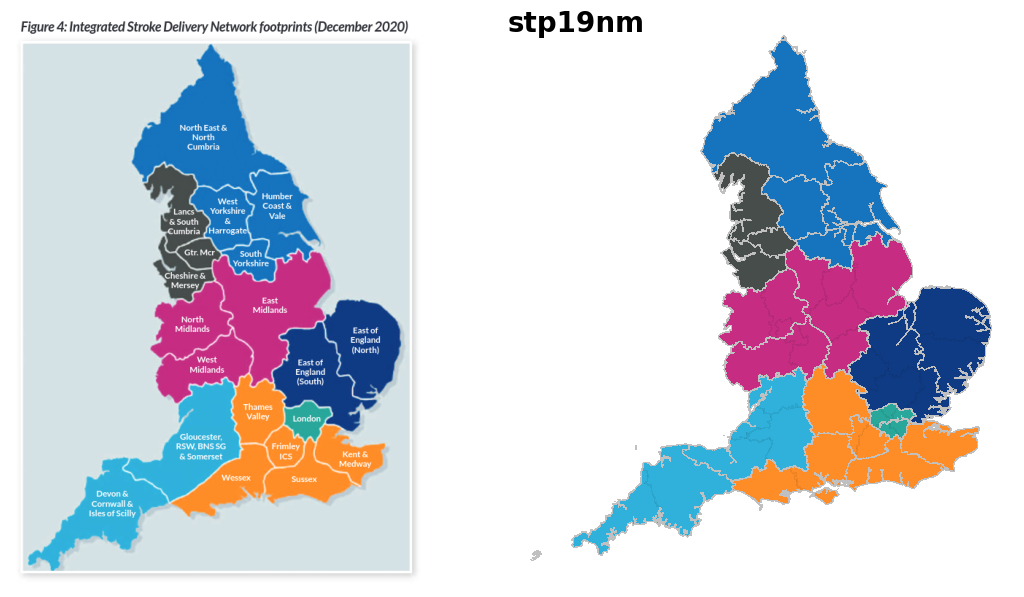

In [17]:
file_input = os.path.join(paths.dir_input, paths.stp2019)
col_name = 'stp19nm'

main(file_input, col_name)

### STP 2020

Index(['OBJECTID', 'stp20cd', 'stp20nm', 'bng_e', 'bng_n', 'long', 'lat',
       'GlobalID', 'geometry'],
      dtype='object')


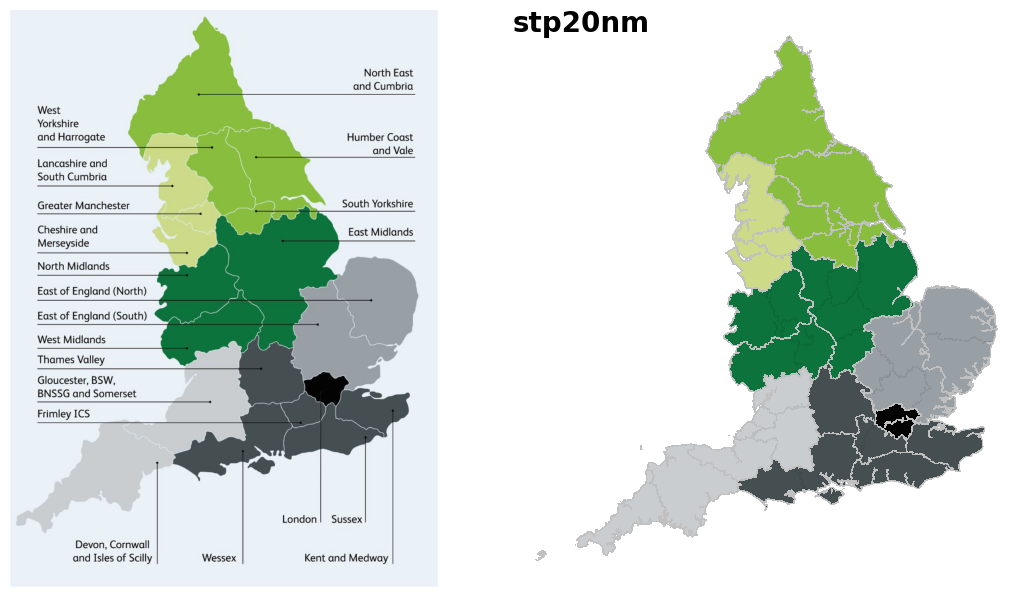

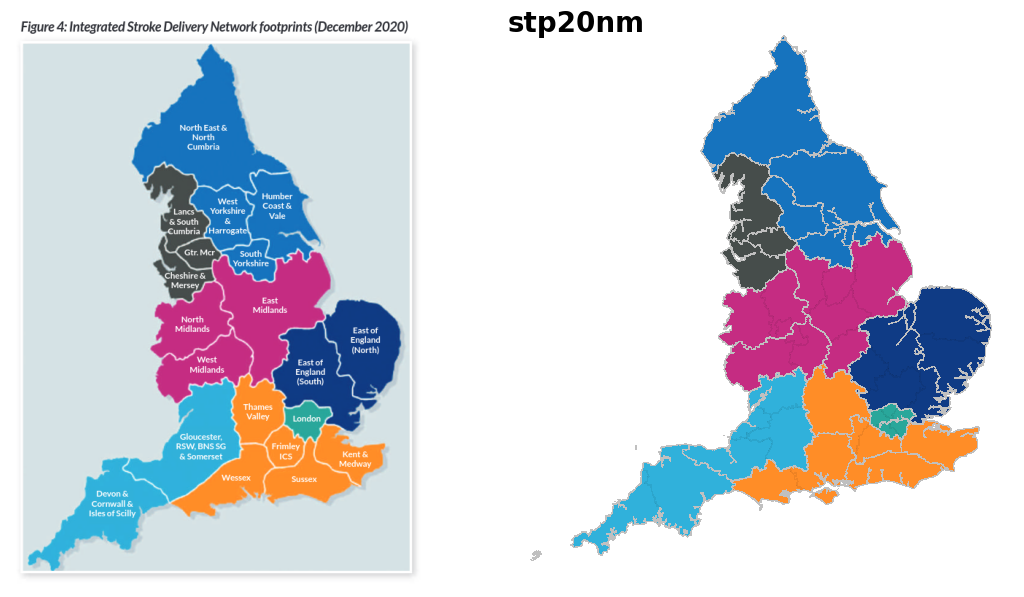

In [18]:
file_input = os.path.join(paths.dir_input, paths.stp2020)
col_name = 'stp20nm'

main(file_input, col_name)

### STP 2021

Index(['OBJECTID', 'STP21CD', 'STP21NM', 'BNG_E', 'BNG_N', 'LONG', 'LAT',
       'GlobalID', 'geometry'],
      dtype='object')


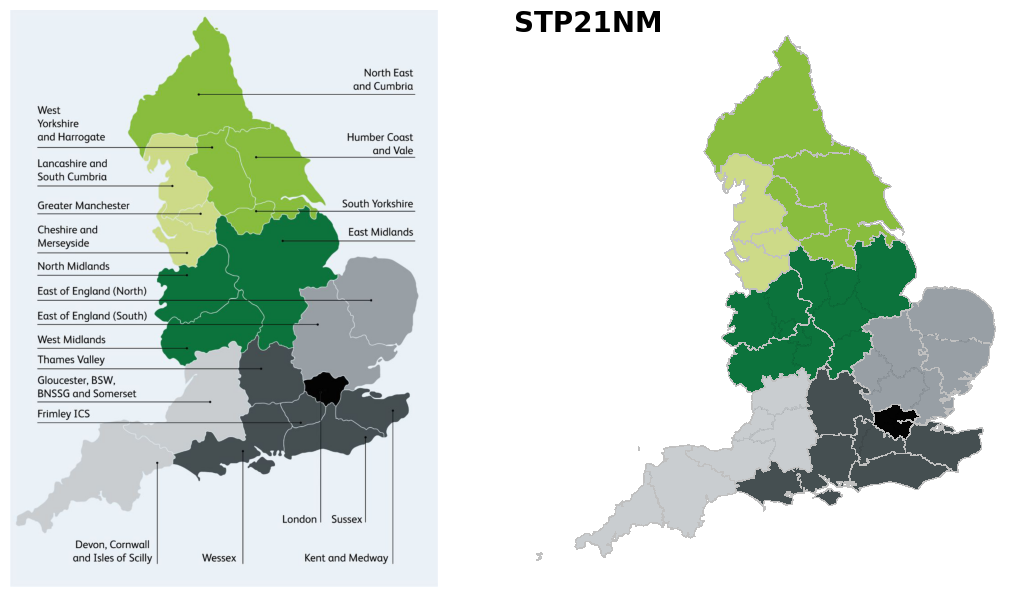

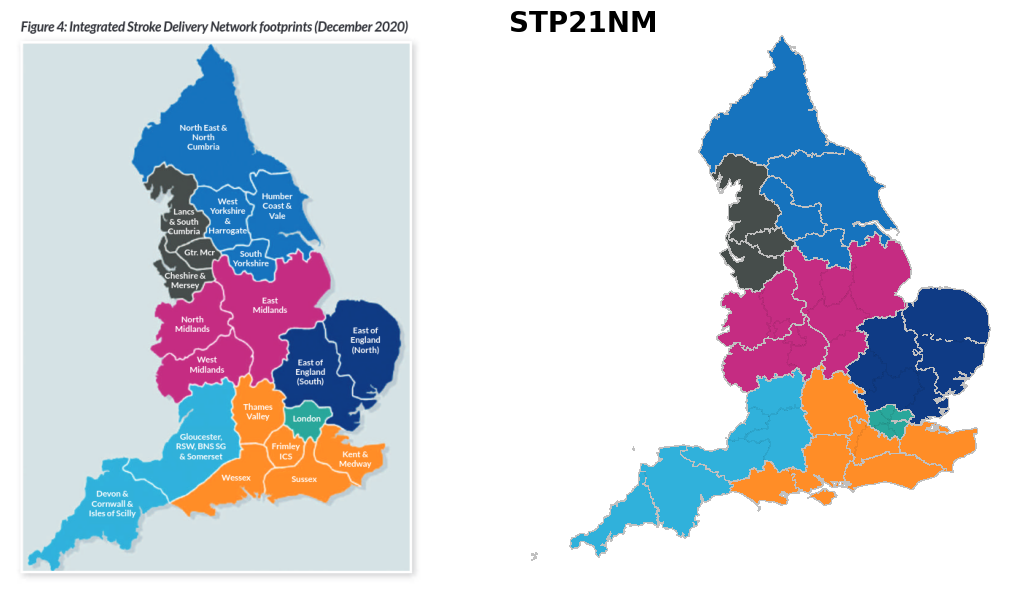

In [19]:
file_input = os.path.join(paths.dir_input, paths.stp2021)
col_name = 'STP21NM'

main(file_input, col_name)

### ICB 2022

Index(['ICB22CD', 'ICB22NM', 'BNG_E', 'BNG_N', 'LONG', 'LAT', 'OBJECTID',
       'geometry'],
      dtype='object')


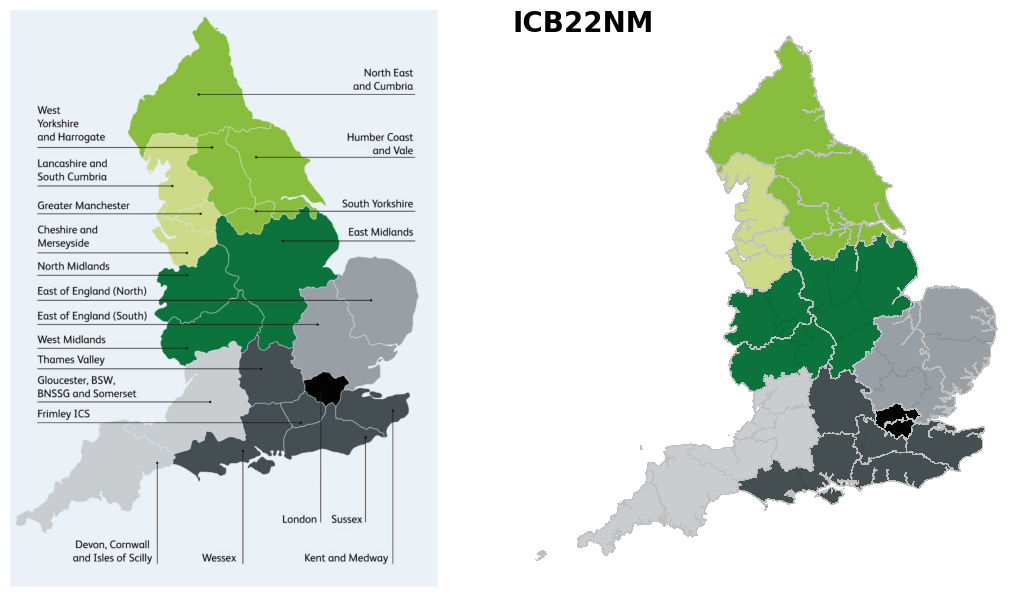

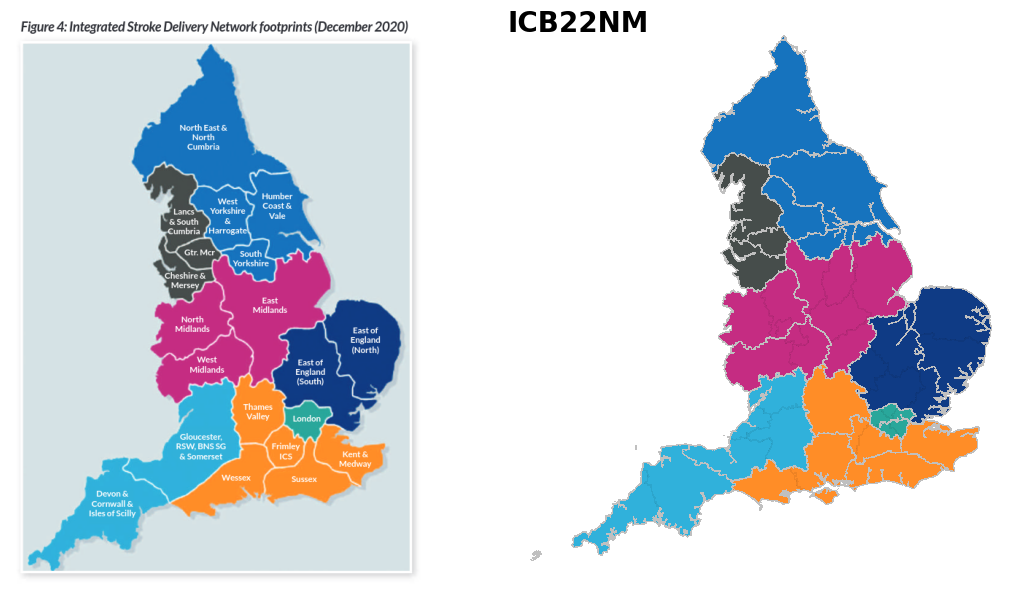

In [20]:
file_input = os.path.join(paths.dir_input, paths.icb2022)
col_name = 'ICB22NM'

main(file_input, col_name)

### ICB 2023

Index(['FID', 'ICB23CD', 'ICB23NM', 'BNG_E', 'BNG_N', 'LONG', 'LAT',
       'GlobalID', 'geometry'],
      dtype='object')


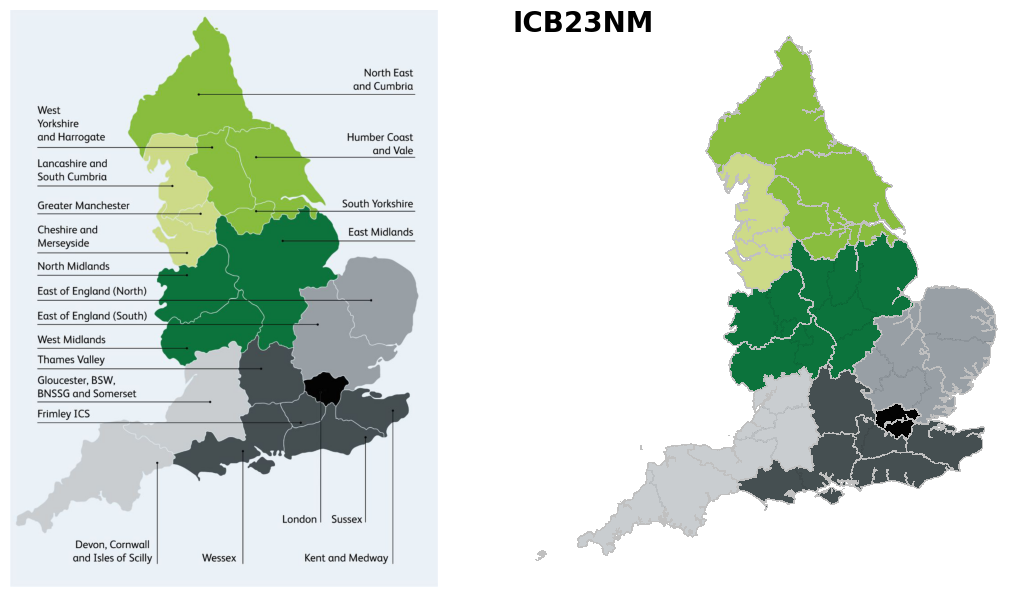

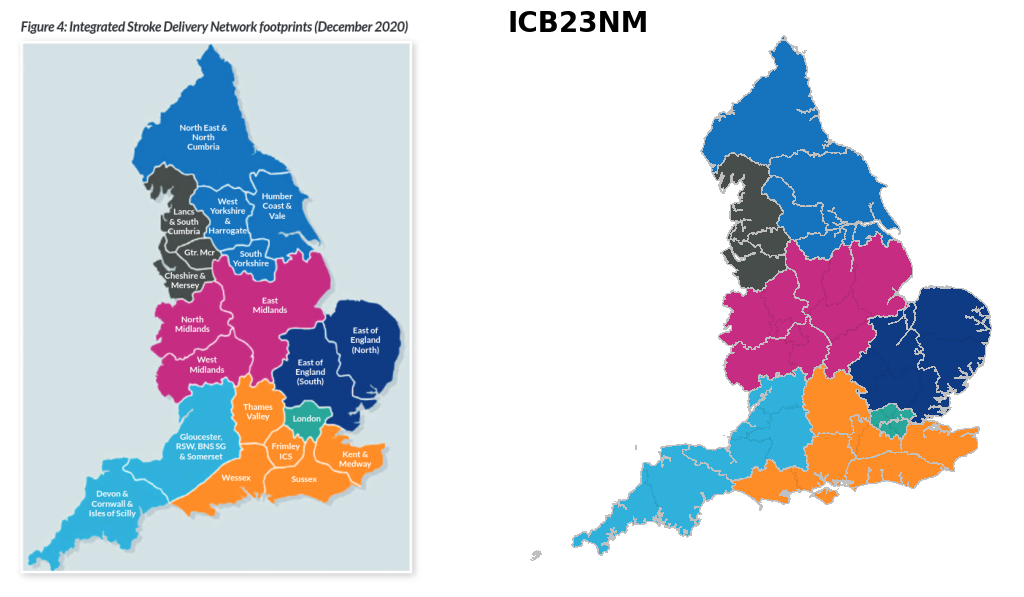

In [21]:
file_input = os.path.join(paths.dir_input, paths.icb2023)
col_name = 'ICB23NM'

main(file_input, col_name)

## Results

### Green reference map:

This is a mix of the STP 2019, STP 2020, and ICB 2022 regions.

| Match | Regions |
| --- | --- |
| STP 2019 only | Sussex north border, "NHS East Surrey CCG". |
| STP 2020 only | "North East and Cumbria" south border. |
| ICB 2022 only | The large "NHS Bassetlaw CCG" area around Worksop (north Notts / south Yorks). |
| None of the above | Border of "North East and Cumbria" ISDN with "West Yorkshire and Harrogate" and "Humber Coast and Vale" ISDN borders. The STP 2020 region named "West Yorkshire and Harrogate" does not actually contain Harrogate, but the STP 2019 region did. In the reference image, the border between "West Yorkshire and Harrogate" ISDN and "Humber Coast and Vale" ISDN is the same at the bottom, then pretends that "West Yorkshire and Harrogate" still contains Harrogate, then continues northwards up to the border with "North East and Cumbria" (as in STP 2020) and meets it near Darlington. |
 
I suspect that these mismatching Yorkshire borders were hand-drawn and contain mistakes. The border does not even match any CCG or SICBL boundaries in any year.

### Multicoloured map:

This most closely matches the STP 2019 regions.

Differences:
+ "Colchester CCG", part of south Suffolk, is in East of England (North) according to the STP data but in East of England (South) on the reference map.
+ The border north of Wessex and south of Somerset etc. is wobbly on the STP data but smooth on the reference map.
  + I suspect this map has been hand-drawn and this border contains mistakes.
 
## Conclusion

There are few differences between the reference images and each pair of maps from the boundary data.

There is no one set of region boundaries that provides a perfect match to either or both reference images.

The reference images seem to use STP region data, and these have now been replaced with ICB.

> __Which data should we use?__ Use the new standard region boundaries, ICB 2022, to define the ISDN boundaries.